In [14]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import datetime
from gym import spaces

In [2]:
# https://www.gymlibrary.ml/environments/box2d/lunar_lander/

In [3]:
# Using OU Noise
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [4]:
def get_actor(num_states, num_actions, upper_bound, continuous=True, layer1=400, layer2=300):
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layer1, activation="relu")(inputs)
    out = layers.Dense(layer2, activation="relu")(out)
    
    # Different output activation based on discrete or continous version
    if continuous:
        outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    else:
        outputs = layers.Dense(num_actions, activation="softmax", kernel_initializer=last_init)(out)

    # Multiply to fill the whole action space which should be equal around 0
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(num_states, num_actions, layer1=400, layer2=300):
    # State as input
    state_input = layers.Input(shape=(num_states))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    action_out = layers.Dense(32, activation="relu")(action_input)

    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(layer1, activation="relu")(concat)
    out = layers.Dense(layer2, activation="relu")(out)

    outputs = layers.Dense(num_actions)(out)

    # Make it into a keras model
    model = tf.keras.Model([state_input, action_input], outputs)

    return model

# This updates the weights in a slow manner which keeps stability
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))

In [5]:
class Agent:
    def __init__(self, num_states, num_actions, lower_bound, upper_bound, continuous=True,
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.002,
            actor_lr=0.001, gamma=0.99, tau=0.005):
        
        self.buffer_capacity = buffer_capacity
        self.batch_size = batch_size
        
        # For methods
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.continuous = continuous

        # This is used to make sure we only sample from used buffer space
        self.buffer_counter = 0

        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        
        self.std_dev = std_dev
        self.critic_lr = critic_lr
        self.actor_lr = actor_lr
        self.gamma = gamma
        self.tau = tau
        
        self.actor_model = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.critic_model = get_critic(num_states, num_actions, layer1=400, layer2=300)

        self.target_actor = get_actor(num_states, num_actions, upper_bound, continuous=continuous, layer1=400, layer2=300)
        self.target_critic = get_critic(num_states, num_actions, layer1=400, layer2=300)
        
        self.critic_optimizer = tf.keras.optimizers.Adam(learning_rate=critic_lr,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
        self.actor_optimizer = tf.keras.optimizers.Adam(learning_rate=actor_lr,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
        
        # Making the weights equal initially
        self.target_actor.set_weights(self.actor_model.get_weights())
        self.target_critic.set_weights(self.critic_model.get_weights())
        
        self.ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
    
    # Makes a record of the outputted (s,a,r,s') obervation tuple
    def record(self, obs_tuple):
        # Reuse the same buffer replacing old entries
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
    
    # Move the update and learn function from buffer to Agent to "decrease" scope
    @tf.function
    def update(self, state_batch, action_batch, reward_batch, next_state_batch,):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)

            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Sample only valid data
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)
        
    def policy(self, state, noise_object=0, use_noise=True, noise_mult=1):
        # Default noise_object to 0 for when it is not needed
        # For doing actions without added noise
        if not use_noise:     
            sampled_actions = tf.squeeze(self.actor_model(state)).numpy()
            legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
        else:
            sampled_actions = tf.squeeze(self.actor_model(state))
            noise = noise_object()
            # Adding noise to action
            sampled_actions = sampled_actions.numpy() + noise * noise_mult

            # We make sure action is within bounds
            legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
            
        if self.continuous:
            return [np.squeeze(legal_action)]
        else:
            return int(np.squeeze(legal_action))

In [6]:
def fixed(x, episode):
    return x

In [36]:
def run(total_trials=1, total_episodes=100, 
            buffer_capacity=50000, batch_size=64, std_dev=0.2, critic_lr=0.0002, render=False,
            actor_lr=0.0001, gamma=0.99, tau=0.005, noise_mult=1, save_weights=True, 
            directory='Weights/', actor_name='actor', critic_name='critic',
            gamma_func=fixed, tau_func=fixed, critic_lr_func=fixed, actor_lr_func=fixed,
            noise_mult_func=fixed, std_dev_func=fixed, mean_number=20, output=True,
            return_rewards=False, total_time=True, use_guide=False, solved=200,
            continuous=True, environment='LunarLander-v2', seed=1453, start_steps=0,
            gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5):
    tot_time = time.time()
    
    if environment == 'LunarLander-v2':
        env = gym.make(
            "LunarLander-v2",
            continuous=continuous,
            gravity=gravity,
            enable_wind=enable_wind,
            wind_power=wind_power,
            turbulence_power=turbulence_power
        )
    else:
        env = gym.make(environment)
        
    # Apply the seed
    _ = env.reset(seed=seed)
    
    # Stepcount for random start
    step = 0
        
    # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # To store reward history of each episode
    ep_reward_list = []
    # To store average reward history of last few episodes
    avg_reward_list = []
    # To separate assisted reward structures from the "true"
    true_reward_list = []
    true_avg_reward_list = []
    
    for trial in range(total_trials):

        # add sublists for each trial
        avg_reward_list.append([])
        ep_reward_list.append([])
        
        true_reward_list.append([])
        true_avg_reward_list.append([])
        
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=buffer_capacity, 
                batch_size=batch_size, std_dev=std_dev, critic_lr=critic_lr, actor_lr=actor_lr, 
                gamma=gamma, tau=tau)

        for ep in range(total_episodes):
            # functions for different parameters
            agent.gamma = gamma_func(gamma, ep)
            agent.tau = tau_func(tau, ep)
            agent.critic_lr = critic_lr_func(critic_lr, ep)
            agent.actor_lr = actor_lr_func(actor_lr, ep)
            agent.noise_mult = noise_mult_func(noise_mult, ep)
            agent.std_dev = std_dev_func(std_dev, ep)
            
            # Used for time benchmarking
            before = time.time()

            prev_state = env.reset()
            episodic_reward = 0
            true_reward = 0

            while True:
                if render:
                    env.render()
                
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

                if step >= start_steps:
                    action = agent.policy(state=tf_prev_state, noise_object=agent.ou_noise, noise_mult=noise_mult)
                    # To get the right format
                    if continuous:
                        action = action[0]
                else:
                    action = env.action_space.sample()
                
                step += 1
                
                # Recieve state and reward from environment.
                state, reward, done, info = env.step(action)
                
                # Add this before eventual reward modification
                true_reward += reward
                
                # Reward modification
                if use_guide:
                    # giving penalty for straying far from flags and having high speed
                    # x max
#                     reward -= int(abs(state[0]) > 0.15) * 2 * abs(state[0])
#                     # y top
#                     reward -= int(state[1] > 1) * state[1] / 2
#                     # horizontal speed
#                     reward -= int(abs(state[2]) > 1) * abs(state[2])
#                     # down speed
#                     reward -= int(state[3] <  -1) * abs(state[3])
#                     # up speed
#                     reward -= int(state[3] > 0.1) * 3 * state[3]
                    reward -= abs(state[2]/2) + abs(state[3]) + (abs(state[0])) + (abs(state[1])/2)

                agent.record((prev_state, action, reward, state))
                episodic_reward += reward

                agent.learn()
                update_target(agent.target_actor.variables, agent.actor_model.variables, agent.tau)
                update_target(agent.target_critic.variables, agent.critic_model.variables, agent.tau)

                # End this episode if en episode is done
                if done:
                    break

                prev_state = state

            ep_reward_list[trial].append(episodic_reward)
            
            true_reward_list[trial].append(true_reward)
            
            true_avg_reward = np.mean(true_reward_list[trial][-mean_number:])
            true_avg_reward_list[trial].append(true_avg_reward)

            # Mean of last x episodes
            avg_reward = np.mean(ep_reward_list[trial][-mean_number:])
            if output:
                print("Ep {} * AvgReward {:.2f} * true AvgReward {:.2f} * Reward {:.2f} * True Reward {:.2f} * time {:.2f} * step {}"
                  .format(ep, avg_reward, true_avg_reward, episodic_reward, true_reward, (time.time() - before), step))
            avg_reward_list[trial].append(avg_reward)
            
            # stop if avg is solved
            if true_avg_reward >= solved:
                break

        # Save weights naming
        now = datetime.datetime.now()
        timestamp = "{}.{}.{}.{}.{}.{}".format(now.year, now.month, now.day, now.hour, now.minute, now.second)
        save_name = environment + '_' + str(total_episodes) + '_' + \
        str(buffer_capacity) + '_' + str(batch_size) + '_' + str(std_dev) + '_' + \
        str(critic_lr) + '_' + str(actor_lr) + '_' + str(gamma) + '_' + str(tau) + '_' + \
        str(noise_mult) + '_' + str(gamma_func.__name__) + '_' + str(tau_func.__name__) + '_' + \
        str(critic_lr_func.__name__) + '_' + str(actor_lr_func.__name__) + '_' + \
        str(noise_mult_func.__name__) + '_' + str(std_dev_func.__name__) + '_' + \
        str(mean_number) + '_' + str(use_guide) + '_' + str(solved) + '_' + \
        str(continuous) + '_' + str(start_steps) + '_' + str(gravity) + '_' + str(enable_wind) + '_' + \
        str(wind_power) + '_' + str(turbulence_power) + '_' + str(timestamp)
        if save_weights:
            agent.actor_model.save_weights(directory + actor_name + '-trial' + str(trial) + '_' + save_name + '.h5')
            agent.critic_model.save_weights(directory + critic_name + '-trial' + str(trial) + '_' + save_name + '.h5')
    
    # Plotting graph
    for idx, p in enumerate(true_avg_reward_list):
        plt.plot(p, label=str(idx))
    plt.xlabel("Episode")
    plt.ylabel("True Avg. Epsiodic Reward (" + str(mean_number) + ")")
    plt.legend()
    plt.savefig('Graphs/' + save_name + '.png')
    plt.show()
    
    print('total time:',time.time() - tot_time, 's')
    
    # Return to be able to make graphs etc. later, or use the data for other stuff
    if return_rewards:
        return true_reward_list

In [31]:
def test(total_episodes=10, actor_weights='Weights/actor-trial0.h5', render=False,
        environment="LunarLander-v2", continuous=True, gravity=-10.0, enable_wind=False,
        wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power
    )
    
        # This is needed to get the input size for the NN
    num_states = env.observation_space.low.shape[0]
    if continuous:
        num_actions = env.action_space.shape[0]
    else:
        num_actions = 1

    # Normalize action space according to https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
    action_space = spaces.Box(low=-1, high=1, shape=(num_actions,), dtype='float32')

    # This is needed to clip the actions within the legal boundaries
    upper_bound = action_space.high[0]
    lower_bound = action_space.low[0]
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        agent = Agent(num_states=num_states, num_actions=num_actions, lower_bound=lower_bound, 
                upper_bound=upper_bound, continuous=continuous, buffer_capacity=0, batch_size=0, 
                std_dev=0, critic_lr=0, actor_lr=0, gamma=0, tau=0)
        agent.actor_model.load_weights(actor_weights)
        
        while True:
            if render:
                env.render()

            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)

            action = agent.policy(state=tf_prev_state, use_noise=False)
            if continuous:
                action = action[0]
            state, reward, done, _ = env.step(action)
            
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

In [32]:
def random(total_episodes=10, render=False, environment="LunarLander-v2", continuous=True,
        gravity=-10.0, enable_wind=False, wind_power=15.0, turbulence_power=1.5, seed=1453):
    rewards = []
    
    env = gym.make(
        environment,
        continuous=continuous,
        gravity=gravity,
        enable_wind=enable_wind,
        wind_power=wind_power,
        turbulence_power=turbulence_power,
    )
    
    # Apply the seed
    _ = env.reset(seed=seed)
    
    for ep in range(total_episodes):
        ep_reward = 0
        
        # Used for time benchmarking
        before = time.time()
        
        prev_state = env.reset()
        
        while True:
            if render:
                env.render()
            action = env.action_space.sample()
            state, reward, done, _ = env.step(action)
            ep_reward += reward

            if done:
                print(str(time.time() - before) + 's')
                rewards.append(ep_reward)
                break

            prev_state = state
            
    plt.plot(rewards)
    plt.xlabel("Episode")
    plt.ylabel("True reward")
    plt.show()

---
# Runs and tests
---

In [10]:
def decreasing_std(x, episode):
    return x/(1+(episode/500))

In [ ]:
def decreasing_lr(x, episode):
    return x/(1+(episode/500))

Ep 0 * AvgReward -205.31 * true AvgReward -205.31 * Reward -205.31 * True Reward -205.31 * time 1.61 * step 92
Ep 1 * AvgReward -174.15 * true AvgReward -174.15 * Reward -142.99 * True Reward -142.99 * time 0.93 * step 189
Ep 2 * AvgReward -162.64 * true AvgReward -162.64 * Reward -139.62 * True Reward -139.62 * time 1.04 * step 294
Ep 3 * AvgReward -231.42 * true AvgReward -231.42 * Reward -437.78 * True Reward -437.78 * time 1.21 * step 403
Ep 4 * AvgReward -249.86 * true AvgReward -249.86 * Reward -323.63 * True Reward -323.63 * time 0.99 * step 496
Ep 5 * AvgReward -222.94 * true AvgReward -222.94 * Reward -88.29 * True Reward -88.29 * time 0.73 * step 563
Ep 6 * AvgReward -208.63 * true AvgReward -208.63 * Reward -122.81 * True Reward -122.81 * time 0.91 * step 642
Ep 7 * AvgReward -212.11 * true AvgReward -212.11 * Reward -236.49 * True Reward -236.49 * time 1.02 * step 740
Ep 8 * AvgReward -234.52 * true AvgReward -234.52 * Reward -413.74 * True Reward -413.74 * time 1.39 * step

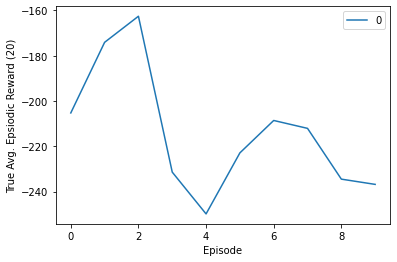

total time: 11.304042100906372 s


In [37]:
run(total_trials=1, total_episodes=10, start_steps=10000, continuous=False, save_weights=True)

Ep 0 * AvgReward -66.91 * true AvgReward -66.91 * Reward -66.91 * True Reward -66.91 * time 2.89 * step 183
Ep 1 * AvgReward -79.16 * true AvgReward -79.16 * Reward -91.42 * True Reward -91.42 * time 1.03 * step 265
Ep 2 * AvgReward -185.53 * true AvgReward -185.53 * Reward -398.27 * True Reward -398.27 * time 1.33 * step 374
Ep 3 * AvgReward -204.60 * true AvgReward -204.60 * Reward -261.81 * True Reward -261.81 * time 1.15 * step 463
Ep 4 * AvgReward -245.05 * true AvgReward -245.05 * Reward -406.84 * True Reward -406.84 * time 1.51 * step 582
Ep 5 * AvgReward -225.01 * true AvgReward -225.01 * Reward -124.84 * True Reward -124.84 * time 0.94 * step 665
Ep 6 * AvgReward -246.62 * true AvgReward -246.62 * Reward -376.23 * True Reward -376.23 * time 1.05 * step 753
Ep 7 * AvgReward -237.23 * true AvgReward -237.23 * Reward -171.53 * True Reward -171.53 * time 0.84 * step 826
Ep 8 * AvgReward -254.77 * true AvgReward -254.77 * Reward -395.10 * True Reward -395.10 * time 1.07 * step 919


Ep 73 * AvgReward -228.81 * true AvgReward -228.81 * Reward -313.14 * True Reward -313.14 * time 1.18 * step 7673
Ep 74 * AvgReward -228.64 * true AvgReward -228.64 * Reward -67.31 * True Reward -67.31 * time 0.94 * step 7765
Ep 75 * AvgReward -227.34 * true AvgReward -227.34 * Reward -95.30 * True Reward -95.30 * time 1.72 * step 7920
Ep 76 * AvgReward -234.55 * true AvgReward -234.55 * Reward -310.67 * True Reward -310.67 * time 1.29 * step 8038
Ep 77 * AvgReward -232.65 * true AvgReward -232.65 * Reward -59.70 * True Reward -59.70 * time 0.80 * step 8111
Ep 78 * AvgReward -234.83 * true AvgReward -234.83 * Reward -251.17 * True Reward -251.17 * time 1.90 * step 8281
Ep 79 * AvgReward -228.27 * true AvgReward -228.27 * Reward -128.13 * True Reward -128.13 * time 1.36 * step 8409
Ep 80 * AvgReward -222.87 * true AvgReward -222.87 * Reward -109.10 * True Reward -109.10 * time 1.79 * step 8568
Ep 81 * AvgReward -214.94 * true AvgReward -214.94 * Reward -28.46 * True Reward -28.46 * time

Ep 144 * AvgReward -999.74 * true AvgReward -999.74 * Reward -743.07 * True Reward -743.07 * time 1.02 * step 14447
Ep 145 * AvgReward -1000.57 * true AvgReward -1000.57 * Reward -791.71 * True Reward -791.71 * time 1.16 * step 14523
Ep 146 * AvgReward -1012.67 * true AvgReward -1012.67 * Reward -1193.48 * True Reward -1193.48 * time 1.86 * step 14646
Ep 147 * AvgReward -1009.10 * true AvgReward -1009.10 * Reward -581.93 * True Reward -581.93 * time 1.46 * step 14748
Ep 148 * AvgReward -1004.66 * true AvgReward -1004.66 * Reward -1806.42 * True Reward -1806.42 * time 2.16 * step 14891
Ep 149 * AvgReward -1003.57 * true AvgReward -1003.57 * Reward -759.48 * True Reward -759.48 * time 0.97 * step 14955
Ep 150 * AvgReward -1004.13 * true AvgReward -1004.13 * Reward -850.57 * True Reward -850.57 * time 1.14 * step 15030
Ep 151 * AvgReward -997.62 * true AvgReward -997.62 * Reward -1048.91 * True Reward -1048.91 * time 1.40 * step 15122
Ep 152 * AvgReward -998.83 * true AvgReward -998.83 * 

Ep 214 * AvgReward -839.90 * true AvgReward -839.90 * Reward -1294.97 * True Reward -1294.97 * time 1.22 * step 20921
Ep 215 * AvgReward -862.81 * true AvgReward -862.81 * Reward -1814.23 * True Reward -1814.23 * time 1.69 * step 21052
Ep 216 * AvgReward -866.29 * true AvgReward -866.29 * Reward -817.20 * True Reward -817.20 * time 0.80 * step 21114
Ep 217 * AvgReward -895.39 * true AvgReward -895.39 * Reward -1896.01 * True Reward -1896.01 * time 1.72 * step 21251
Ep 218 * AvgReward -923.19 * true AvgReward -923.19 * Reward -1832.11 * True Reward -1832.11 * time 2.16 * step 21402
Ep 219 * AvgReward -931.51 * true AvgReward -931.51 * Reward -705.50 * True Reward -705.50 * time 1.02 * step 21464
Ep 220 * AvgReward -933.65 * true AvgReward -933.65 * Reward -812.06 * True Reward -812.06 * time 1.11 * step 21536
Ep 221 * AvgReward -944.03 * true AvgReward -944.03 * Reward -1477.13 * True Reward -1477.13 * time 2.30 * step 21690
Ep 222 * AvgReward -943.27 * true AvgReward -943.27 * Reward -

Ep 285 * AvgReward -1133.38 * true AvgReward -1133.38 * Reward -788.51 * True Reward -788.51 * time 0.92 * step 27794
Ep 286 * AvgReward -1147.95 * true AvgReward -1147.95 * Reward -719.28 * True Reward -719.28 * time 0.84 * step 27851
Ep 287 * AvgReward -1168.03 * true AvgReward -1168.03 * Reward -1114.64 * True Reward -1114.64 * time 1.30 * step 27941
Ep 288 * AvgReward -1142.51 * true AvgReward -1142.51 * Reward -1652.79 * True Reward -1652.79 * time 1.73 * step 28063
Ep 289 * AvgReward -1148.01 * true AvgReward -1148.01 * Reward -1248.84 * True Reward -1248.84 * time 1.23 * step 28157
Ep 290 * AvgReward -1146.14 * true AvgReward -1146.14 * Reward -778.39 * True Reward -778.39 * time 0.98 * step 28220
Ep 291 * AvgReward -1145.85 * true AvgReward -1145.85 * Reward -1721.02 * True Reward -1721.02 * time 1.58 * step 28339
Ep 292 * AvgReward -1164.58 * true AvgReward -1164.58 * Reward -1734.12 * True Reward -1734.12 * time 1.64 * step 28460
Ep 293 * AvgReward -1164.83 * true AvgReward -

Ep 354 * AvgReward -975.14 * true AvgReward -975.14 * Reward -754.11 * True Reward -754.11 * time 1.02 * step 33959
Ep 355 * AvgReward -983.93 * true AvgReward -983.93 * Reward -1206.12 * True Reward -1206.12 * time 1.29 * step 34051
Ep 356 * AvgReward -994.45 * true AvgReward -994.45 * Reward -1629.19 * True Reward -1629.19 * time 1.69 * step 34173
Ep 357 * AvgReward -983.63 * true AvgReward -983.63 * Reward -795.91 * True Reward -795.91 * time 0.93 * step 34235
Ep 358 * AvgReward -1002.93 * true AvgReward -1002.93 * Reward -1688.09 * True Reward -1688.09 * time 1.60 * step 34356
Ep 359 * AvgReward -1016.34 * true AvgReward -1016.34 * Reward -1389.45 * True Reward -1389.45 * time 1.50 * step 34459
Ep 360 * AvgReward -1021.78 * true AvgReward -1021.78 * Reward -1200.59 * True Reward -1200.59 * time 1.39 * step 34552
Ep 361 * AvgReward -1031.20 * true AvgReward -1031.20 * Reward -1617.56 * True Reward -1617.56 * time 1.88 * step 34677
Ep 362 * AvgReward -1010.93 * true AvgReward -1010.9

Ep 424 * AvgReward -989.48 * true AvgReward -989.48 * Reward -736.93 * True Reward -736.93 * time 0.95 * step 40757
Ep 425 * AvgReward -993.06 * true AvgReward -993.06 * Reward -875.10 * True Reward -875.10 * time 1.16 * step 40841
Ep 426 * AvgReward -1003.50 * true AvgReward -1003.50 * Reward -1152.12 * True Reward -1152.12 * time 1.43 * step 40950
Ep 427 * AvgReward -1007.82 * true AvgReward -1007.82 * Reward -1255.47 * True Reward -1255.47 * time 1.56 * step 41057
Ep 428 * AvgReward -1004.34 * true AvgReward -1004.34 * Reward -717.91 * True Reward -717.91 * time 0.84 * step 41112
Ep 429 * AvgReward -1002.76 * true AvgReward -1002.76 * Reward -718.42 * True Reward -718.42 * time 0.83 * step 41171
Ep 430 * AvgReward -1003.26 * true AvgReward -1003.26 * Reward -899.56 * True Reward -899.56 * time 1.06 * step 41253
Ep 431 * AvgReward -999.18 * true AvgReward -999.18 * Reward -688.69 * True Reward -688.69 * time 0.92 * step 41321
Ep 432 * AvgReward -1003.57 * true AvgReward -1003.57 * Re

Ep 495 * AvgReward -939.76 * true AvgReward -939.76 * Reward -1410.74 * True Reward -1410.74 * time 1.62 * step 46944
Ep 496 * AvgReward -981.91 * true AvgReward -981.91 * Reward -2436.10 * True Reward -2436.10 * time 2.96 * step 47135
Ep 497 * AvgReward -955.18 * true AvgReward -955.18 * Reward -800.98 * True Reward -800.98 * time 1.05 * step 47203
Ep 498 * AvgReward -969.25 * true AvgReward -969.25 * Reward -1263.14 * True Reward -1263.14 * time 1.60 * step 47308
Ep 499 * AvgReward -992.05 * true AvgReward -992.05 * Reward -1632.27 * True Reward -1632.27 * time 1.78 * step 47426
Ep 500 * AvgReward -1011.81 * true AvgReward -1011.81 * Reward -1522.88 * True Reward -1522.88 * time 1.71 * step 47543
Ep 501 * AvgReward -1027.87 * true AvgReward -1027.87 * Reward -1907.18 * True Reward -1907.18 * time 2.04 * step 47674
Ep 502 * AvgReward -1025.71 * true AvgReward -1025.71 * Reward -756.08 * True Reward -756.08 * time 0.91 * step 47733
Ep 503 * AvgReward -1020.16 * true AvgReward -1020.16 

Ep 564 * AvgReward -1067.82 * true AvgReward -1067.82 * Reward -825.81 * True Reward -825.81 * time 0.93 * step 53331
Ep 565 * AvgReward -1053.72 * true AvgReward -1053.72 * Reward -849.35 * True Reward -849.35 * time 1.01 * step 53401
Ep 566 * AvgReward -1051.33 * true AvgReward -1051.33 * Reward -1154.60 * True Reward -1154.60 * time 1.27 * step 53489
Ep 567 * AvgReward -1039.79 * true AvgReward -1039.79 * Reward -735.98 * True Reward -735.98 * time 0.88 * step 53549
Ep 568 * AvgReward -1044.74 * true AvgReward -1044.74 * Reward -1150.46 * True Reward -1150.46 * time 1.39 * step 53639
Ep 569 * AvgReward -1044.43 * true AvgReward -1044.43 * Reward -774.14 * True Reward -774.14 * time 0.89 * step 53698
Ep 570 * AvgReward -1064.79 * true AvgReward -1064.79 * Reward -1804.06 * True Reward -1804.06 * time 2.00 * step 53823
Ep 571 * AvgReward -1092.39 * true AvgReward -1092.39 * Reward -1693.21 * True Reward -1693.21 * time 1.77 * step 53943
Ep 572 * AvgReward -1097.92 * true AvgReward -10

Ep 633 * AvgReward -1051.84 * true AvgReward -1051.84 * Reward -787.32 * True Reward -787.32 * time 0.87 * step 59422
Ep 634 * AvgReward -1042.28 * true AvgReward -1042.28 * Reward -916.80 * True Reward -916.80 * time 1.19 * step 59519
Ep 635 * AvgReward -1044.89 * true AvgReward -1044.89 * Reward -836.84 * True Reward -836.84 * time 0.81 * step 59588
Ep 636 * AvgReward -1050.86 * true AvgReward -1050.86 * Reward -1007.47 * True Reward -1007.47 * time 1.36 * step 59678
Ep 637 * AvgReward -1049.68 * true AvgReward -1049.68 * Reward -832.04 * True Reward -832.04 * time 1.10 * step 59763
Ep 638 * AvgReward -1039.94 * true AvgReward -1039.94 * Reward -857.54 * True Reward -857.54 * time 1.00 * step 59835
Ep 639 * AvgReward -1039.31 * true AvgReward -1039.31 * Reward -832.76 * True Reward -832.76 * time 1.05 * step 59915
Ep 640 * AvgReward -1016.82 * true AvgReward -1016.82 * Reward -815.97 * True Reward -815.97 * time 1.03 * step 59987
Ep 641 * AvgReward -1027.41 * true AvgReward -1027.41 

Ep 703 * AvgReward -964.77 * true AvgReward -964.77 * Reward -732.38 * True Reward -732.38 * time 0.98 * step 65230
Ep 704 * AvgReward -957.55 * true AvgReward -957.55 * Reward -842.01 * True Reward -842.01 * time 1.04 * step 65299
Ep 705 * AvgReward -948.85 * true AvgReward -948.85 * Reward -921.76 * True Reward -921.76 * time 1.19 * step 65381
Ep 706 * AvgReward -949.82 * true AvgReward -949.82 * Reward -771.45 * True Reward -771.45 * time 0.99 * step 65446
Ep 707 * AvgReward -951.16 * true AvgReward -951.16 * Reward -894.68 * True Reward -894.68 * time 1.13 * step 65521
Ep 708 * AvgReward -966.00 * true AvgReward -966.00 * Reward -1328.92 * True Reward -1328.92 * time 1.49 * step 65625
Ep 709 * AvgReward -963.04 * true AvgReward -963.04 * Reward -702.71 * True Reward -702.71 * time 0.82 * step 65680
Ep 710 * AvgReward -963.49 * true AvgReward -963.49 * Reward -768.09 * True Reward -768.09 * time 0.90 * step 65745
Ep 711 * AvgReward -978.50 * true AvgReward -978.50 * Reward -1438.38 

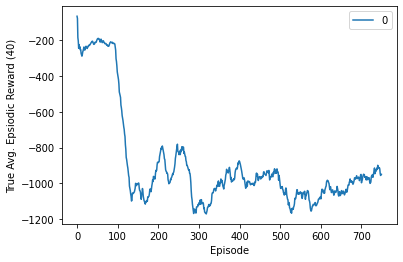

total time: 968.1444172859192 s


In [12]:
run(total_episodes=750, start_steps=10000, save_weights=True)

In [13]:
#test(render=True, continuous=False, total_episodes=3)